In [1]:
# Проект Дашборд конверсий

In [3]:
## Загрузка библиотек

In [41]:
import os
import pandas as pd
import requests as req
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from dotenv import load_dotenv

load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

resp = req.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})
resp_visits = req.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})

In [42]:
## Чтение и выборка зарегистрированных и посещаемых пользователей

In [43]:
visitors = pd.DataFrame(resp_visits.json())
regs = pd.DataFrame(resp.json())
visitors['datetime'] = pd.to_datetime(visitors['datetime']).dt.date
regs['datetime'] = pd.to_datetime(regs['datetime']).dt.date

In [44]:
regs.head()

,datetime,user_id,email,platform,registration_type
0,2023-03-01,2e0f6bb8-b029-4f45-a786-2b53990d37f1,ebyrd@example.org,web,google
1,2023-03-01,f007f97c-9d8b-48b5-af08-119bb8f6d9b6,knightgerald@example.org,web,email
2,2023-03-01,24ff46ae-32b3-4a74-8f27-7cf0b8f32f15,cherylthompson@example.com,web,apple
3,2023-03-01,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60,halldavid@example.org,web,email
4,2023-03-01,27f875fc-f8ce-4aeb-8722-0ecb283d0760,denise86@example.net,web,google


In [45]:
visitors.head(100)

,visit_id,platform,user_agent,datetime
0,1de9ea66-70d3-4a1f-8735-df5ef7697fb9,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
1,f149f542-e935-4870-9734-6b4501eaf614,web,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,2023-03-01
2,08f0ebd4-950c-4dd9-8e97-b5bdf073eed1,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,2023-03-01
3,19322fed-157c-49c6-b16e-2d5cabeb9592,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,2023-03-01
4,04762a22-3c9f-40c9-9ac9-6628c4381836,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
...,...,...,...,...
95,79cf0607-cb47-4aac-b811-84f95ddbb589,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
96,e363bad9-23d8-4263-aa84-727e10b07891,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
97,54ef7f95-9688-4018-a535-7be9e7c5af18,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
98,c0c16b36-c0ea-42d1-9950-a263faec571d,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01


In [46]:
## Анализ зарегистрированных пользователей

In [47]:
visitors.describe()

,visit_id,platform,user_agent,datetime
count,263459,263459,263459,263459
unique,146085,4,32,184
top,cda0796e-3d55-455d-bdb7-c6af96cc5a0e,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-03-08
freq,4,236301,13623,2624


In [48]:
## Анализ посещаемых пользователей

In [49]:
regs.describe()

,datetime,user_id,email,platform,registration_type
count,21836,21836,21836,21836,21836
unique,184,21836,20868,3,4
top,2023-03-06,fe03e08a-8e86-4b5f-9a50-c18a02b0d234,ujones@example.com,android,email
freq,230,1,6,10582,8996


In [50]:
## Регистрация уникальных пользователей

In [51]:
visitors = visitors.drop_duplicates(subset="visit_id", keep="last")
visitors = visitors[~visitors['platform'].isin(['bot'])]

In [52]:
## Группировка пользователей

In [53]:
grouped_regs = regs.groupby(['datetime', 'platform'])['datetime'].count().reset_index(name='registrations')

In [54]:
grouped_regs.head()

,datetime,platform,registrations
0,2023-03-01,android,61
1,2023-03-01,ios,18
2,2023-03-01,web,8
3,2023-03-02,android,59
4,2023-03-02,ios,24


In [55]:
grouped_visitors = visitors.groupby(['datetime', 'platform'])['datetime'].count().reset_index(name='visits')

In [56]:
grouped_visitors.head(100)

,datetime,platform,visits
0,2023-03-01,android,75
1,2023-03-01,ios,22
2,2023-03-01,web,787
3,2023-03-02,android,67
4,2023-03-02,ios,31
...,...,...,...
95,2023-04-01,web,729
96,2023-04-02,android,69
97,2023-04-02,ios,60
98,2023-04-02,web,705


In [57]:
## Соединение таблиц и расчет конверсии

In [58]:
conversion = pd.merge(
    grouped_visitors, grouped_regs
)
conversion = conversion.rename(columns={'datetime': 'date_group'})
conversion['conversion'] = (conversion['registrations'] / conversion['visits']) * 100
conversion.sort_values(by='date_group', inplace=True)
conversion.to_json('./conversion.json')

In [59]:
conversion.head()

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,787,8,1.016518
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355


In [60]:
## Загружаем данные по рекламным компаниями

In [61]:
ads = pd.read_csv('./ads.csv')
ads['date'] = pd.to_datetime(ads['date']).dt.date
ads.head()
group_ads = ads.groupby('date')
group_ads.head()

,date,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01,google,cpc,advanced_algorithms_series,212
1,2023-03-02,google,cpc,advanced_algorithms_series,252
2,2023-03-03,google,cpc,advanced_algorithms_series,202
3,2023-03-04,google,cpc,advanced_algorithms_series,223
4,2023-03-05,google,cpc,advanced_algorithms_series,265
...,...,...,...,...,...
154,2023-09-13,vk,social,intro_to_python_course,277
155,2023-09-14,vk,social,intro_to_python_course,221
156,2023-09-15,vk,social,intro_to_python_course,175
157,2023-09-16,vk,social,intro_to_python_course,224


In [62]:
## Группируем рекламу по дате и объединяем с конверсией

In [63]:
conversion_ads = pd.merge(
    conversion, ads, left_on='date_group', right_on='date'
)
conversion_ads = conversion_ads.fillna({'utm_campaign': 'none', 'cost': 0})
conversion_ads.sort_values(by='date_group', inplace=True)
conversion_ads.head()
conversion_ads = conversion_ads[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]
conversion_ads.head()
conversion.to_json('./ads_conversion.json')

In [64]:
## Визуализируем данные на графиках с помощью matplotlib.pyplot, seaborn, plotly

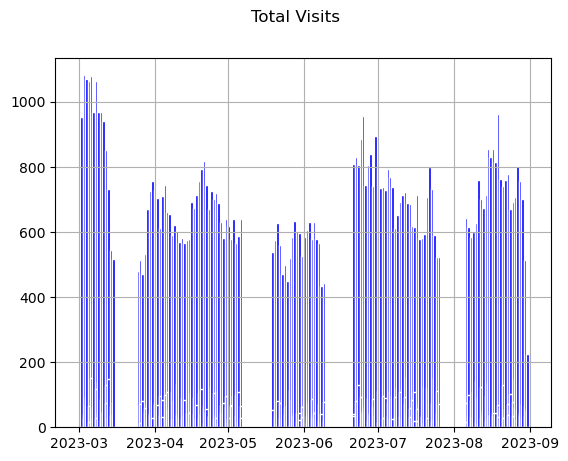

In [65]:
# sns.barplot(x="date_group", y="visits", data=conversion_ads, color='skyblue')
fig, ax = plt.subplots()
fig.suptitle("Total Visits")
# fig.set_size_inches((10, 10))
ax.bar(conversion_ads['date_group'],
       conversion_ads['visits'],
       width=1,
       color='blue',
       edgecolor="white"
      )
ax.grid()

plt.show()